In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from rdkit import Chem
from rdkit.Chem import AllChem
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from models.HEGNN import HEGNN  

C:\Users\jonat\AppData\Local\Temp\ipykernel_24624\2068214821.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
# Load the data
train_df = pd.read_excel('Training_data_cleaned.xlsx')
val_df = pd.read_excel('Validation_data_cleaned.xlsx')
test_df = pd.read_excel('Test_data_cleaned.xlsx')

# While testing, only use the first 500 samples
train_df = train_df.iloc[:500]
val_df = val_df.iloc[:500]
test_df = test_df.iloc[:500]

In [ ]:
from tqdm import tqdm
class MoleculeDataset(Dataset):
    """
    Custom Dataset for molecule data.

    Args:
        dataframe (pd.DataFrame): DataFrame containing molecule data.
    """
    def __init__(self, dataframe: pd.DataFrame):
        self.data_list = []
        for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
            smiles = row['Main_Component']
            label = row['Function']
            try:
                mol = Chem.MolFromSmiles(smiles)
            except:
                mol = None
                print(f'Failed to process SMILES: {smiles}')
            if mol is None:
                continue
            data = mol_to_graph_data(mol)
            if data is None:
                continue
            data.y = torch.tensor([label], dtype=torch.float)
            self.data_list.append(data)

    def __len__(self) -> int:
        return len(self.data_list)

    def __getitem__(self, idx: int):
        return self.data_list[idx]

def atom_features(atom):
    """
    Returns a list of atom features.

    Args:
        atom (Chem.Atom): RDKit atom object.

    Returns:
        List[float]: List of features.
    """
    features = []
    features.append(atom.GetAtomicNum())
    features.append(atom.GetDegree())
    features.append(atom.GetFormalCharge())
    features.append(atom.GetNumRadicalElectrons())
    features.append(int(atom.GetHybridization()))
    features.append(int(atom.GetIsAromatic()))
    return features


def mol_to_graph_data(mol: Chem.Mol) -> Data:
    """
    Converts an RDKit Mol object to a PyTorch Geometric Data object.

    Args:
        mol (Chem.Mol): RDKit molecule object.

    Returns:
        data (Data): PyTorch Geometric Data object.
    """
    # Add hydrogens and generate 3D coordinates
    mol = Chem.AddHs(mol)
    success = AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    if success != 0:
        return None  # Failed to generate conformer
    AllChem.UFFOptimizeMolecule(mol)

    # Nodes
    num_atoms = mol.GetNumAtoms()
    node_feats = []
    node_positions = []
    for atom in mol.GetAtoms():
        node_feats.append(atom_features(atom))
        pos = mol.GetConformer().GetAtomPosition(atom.GetIdx())
        node_positions.append([pos.x, pos.y, pos.z])

    node_feats = torch.tensor(node_feats, dtype=torch.float)
    node_positions = torch.tensor(node_positions, dtype=torch.float)

    # Edges
    edge_index = []
    edge_attrs = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.extend([[i, j], [j, i]])  # Undirected
        bond_type = bond.GetBondTypeAsDouble()
        edge_attrs.extend([[bond_type], [bond_type]])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attrs = torch.tensor(edge_attrs, dtype=torch.float)

    # Node velocities (assuming zeros)
    node_velocities = torch.zeros_like(node_positions)

    data = Data(
        x=node_feats,
        pos=node_positions,
        vel=node_velocities,
        edge_index=edge_index,
        edge_attr=edge_attrs,
    )

    return data


In [7]:
# Create datasets
train_dataset = MoleculeDataset(train_df)
val_dataset = MoleculeDataset(val_df)
test_dataset = MoleculeDataset(test_df)

# Create DataLoaders
batch_size = 32
print(f"Number of training samples: {len(train_dataset)}")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(f"Number of validation samples: {len(val_dataset)}")
val_loader = DataLoader(val_dataset, batch_size=batch_size)
print(f"Number of test samples: {len(test_dataset)}")
test_loader = DataLoader(test_dataset, batch_size=batch_size)


  5%|▌         | 27/500 [00:33<08:07,  1.03s/it][09:30:31] UFFTYPER: Unrecognized atom type: Ni6+2 (1)
[09:30:31] UFFTYPER: Unrecognized atom type: Ni6+2 (1)
[09:30:31] UFFTYPER: Unrecognized charge state for atom: 1
[09:30:31] UFFTYPER: Unrecognized charge state for atom: 1
 22%|██▏       | 112/500 [00:36<00:25, 14.94it/s][09:30:34] UFFTYPER: Unrecognized atom type: Zr3 (1)
[09:30:34] UFFTYPER: Unrecognized atom type: Zr3 (1)
 42%|████▏     | 210/500 [00:53<00:38,  7.61it/s][09:30:51] UFFTYPER: Unrecognized atom type: Pd6+2 (1)
[09:30:51] UFFTYPER: Unrecognized atom type: Pd6+2 (1)
 12%|█▏        | 62/500 [00:07<00:18, 23.87it/s][09:31:22] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[09:31:22] UFFTYPER: Unrecognized charge state for atom: 1
[09:31:22] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[09:31:22] UFFTYPER: Unrecognized charge state for atom: 1
 23%|██▎       | 115/500 [00:11<00:22, 16.83it/s][09:31:26] UFFTYPER: Unrecognized atom type: Zr2 (1)
[09:31:26]

Number of training samples: 498
Number of validation samples: 500
Number of test samples: 496


In [ ]:
# Initialize the HEGNN model and classifier
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model parameters
num_layers = 3
mol = Chem.MolFromSmiles('CCO')
node_input_dim = len(atom_features(mol.GetAtomWithIdx(0)))
edge_attr_dim = 1   # Bond type
hidden_dim = 64
max_ell = 2  # Example value

# Initialize the HEGNN
heg_nn = HEGNN(
    num_layer=num_layers,
    node_input_dim=node_input_dim,
    edge_attr_dim=edge_attr_dim,
    hidden_dim=hidden_dim,
    max_ell=max_ell,
    activation=nn.SiLU(),
    device=device
).to(device)

class HEGNNClassifier(nn.Module):
    """
    Model that combines HEGNN and a linear classifier.

    Args:
        heg_nn (HEGNN): The HEGNN model.
        hidden_dim (int): Dimension of the HEGNN output.
    """
    def __init__(self, heg_nn: HEGNN, hidden_dim: int):
        super(HEGNNClassifier, self).__init__()
        self.heg_nn = heg_nn
        self.classifier = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, data):
        node_feat = data.x
        node_pos = data.pos
        node_vel = data.vel
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        batch = data.batch

        node_embeddings = self.heg_nn(node_feat, node_pos, node_vel, edge_index, edge_attr)
        graph_embeddings = global_mean_pool(node_embeddings, batch)
        out = self.classifier(graph_embeddings)
        return out, graph_embeddings

# Initialize the classifier model
model = HEGNNClassifier(heg_nn, hidden_dim).to(device)


In [9]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [10]:
def train(model: nn.Module, loader: DataLoader) -> float:
    """
    Training loop for one epoch.

    Args:
        model (nn.Module): The model to train.
        loader (DataLoader): DataLoader for training data.

    Returns:
        float: Average loss over the epoch.
    """
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out, _ = model(data)
        label = data.y.view(-1, 1)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)


In [12]:
def evaluate(model: nn.Module, loader: DataLoader) -> tuple[float, np.ndarray, np.ndarray]:
    """
    Evaluation loop.

    Args:
        model (nn.Module): The model to evaluate.
        loader (DataLoader): DataLoader for validation or test data.

    Returns:
        Tuple[float, np.ndarray, np.ndarray]: Average loss, predictions, and labels.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out, _ = model(data)
            label = data.y.view(-1, 1)
            loss = criterion(out, label)
            total_loss += loss.item() * data.num_graphs
            preds = torch.sigmoid(out).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(label.cpu().numpy())
    return total_loss / len(loader.dataset), np.array(all_preds), np.array(all_labels)


In [15]:
# Training loop execution
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_loader)
    val_loss, val_preds, val_labels = evaluate(model, val_loader)
    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


Epoch 1, Train Loss: 0.7080, Validation Loss: 0.7083
Epoch 2, Train Loss: 0.7080, Validation Loss: 0.7083
Epoch 3, Train Loss: 0.7080, Validation Loss: 0.7083
Epoch 4, Train Loss: 0.7080, Validation Loss: 0.7083
Epoch 5, Train Loss: 0.7080, Validation Loss: 0.7083
Epoch 6, Train Loss: 0.7080, Validation Loss: 0.7083
Epoch 7, Train Loss: 0.7080, Validation Loss: 0.7083
Epoch 8, Train Loss: 0.7080, Validation Loss: 0.7083
Epoch 9, Train Loss: 0.7080, Validation Loss: 0.7083
Epoch 10, Train Loss: 0.7080, Validation Loss: 0.7083
Epoch 11, Train Loss: 0.7080, Validation Loss: 0.7083
Epoch 12, Train Loss: 0.7080, Validation Loss: 0.7083
Epoch 13, Train Loss: 0.7080, Validation Loss: 0.7083
Epoch 14, Train Loss: 0.7080, Validation Loss: 0.7083
Epoch 15, Train Loss: 0.7080, Validation Loss: 0.7083
Epoch 16, Train Loss: 0.7080, Validation Loss: 0.7083
Epoch 17, Train Loss: 0.7080, Validation Loss: 0.7083
Epoch 18, Train Loss: 0.7080, Validation Loss: 0.7083
Epoch 19, Train Loss: 0.7080, Validat

In [17]:
def get_embeddings_and_labels(model: nn.Module, loader: DataLoader) -> tuple[np.ndarray, np.ndarray]:
    """
    Extracts graph embeddings and labels from the model.

    Args:
        model (nn.Module): The trained model.
        loader (DataLoader): DataLoader for the dataset.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Embeddings and labels.
    """
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out, graph_embeddings = model(data)
            embeddings.append(graph_embeddings.cpu())
            labels.append(data.y.cpu())
    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    return embeddings.numpy(), labels.numpy()


In [18]:
# Get embeddings and labels
train_embeddings, train_labels = get_embeddings_and_labels(model, train_loader)
val_embeddings, val_labels = get_embeddings_and_labels(model, val_loader)
test_embeddings, test_labels = get_embeddings_and_labels(model, test_loader)


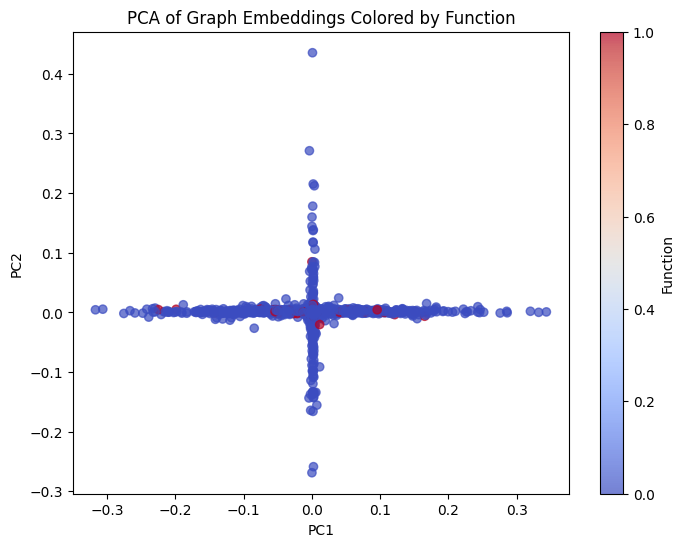

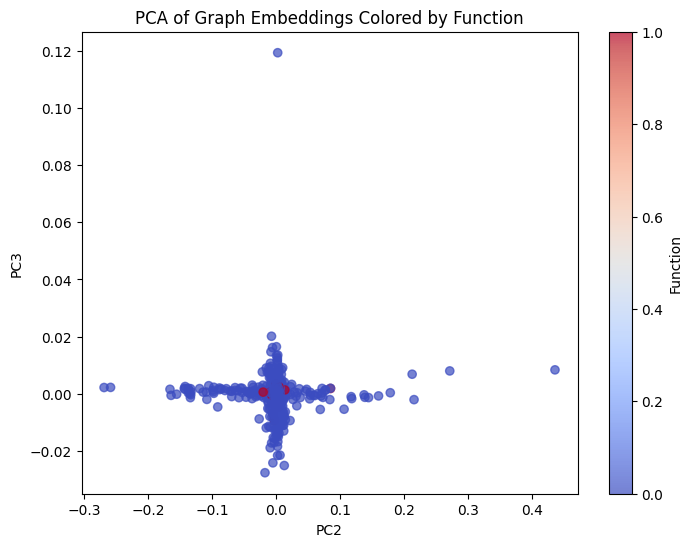

In [21]:
# Perform PCA and plot embeddings
from sklearn.decomposition import PCA

# Combine embeddings and labels
all_embeddings = np.concatenate([train_embeddings, val_embeddings, test_embeddings], axis=0)
all_labels = np.concatenate([train_labels, val_labels, test_labels], axis=0)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_embeddings)

# Plot PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=all_labels.squeeze(), cmap='coolwarm', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Graph Embeddings Colored by Function')
plt.colorbar(scatter, label='Function')
plt.show()

# Also plot PCA2 and PCA3
pca = PCA(n_components=3)
pca_result = pca.fit_transform(all_embeddings)

# Plot PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_result[:, 1], pca_result[:, 2], c=all_labels.squeeze(), cmap='coolwarm', alpha=0.7)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('PCA of Graph Embeddings Colored by Function')
plt.colorbar(scatter, label='Function')
plt.show()


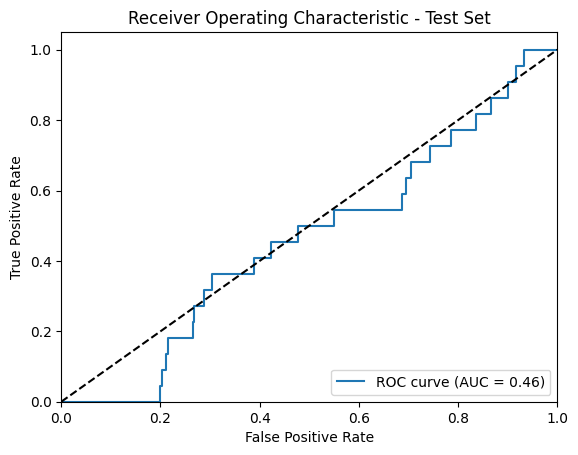

In [ ]:
# Train a linear classifier on the embeddings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

# Prepare training and test data
X_train = train_embeddings
y_train = train_labels.squeeze()
X_test = test_embeddings
y_test = test_labels.squeeze()

# Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict probabilities
y_scores = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Test Set')
plt.legend(loc='lower right')
plt.show()


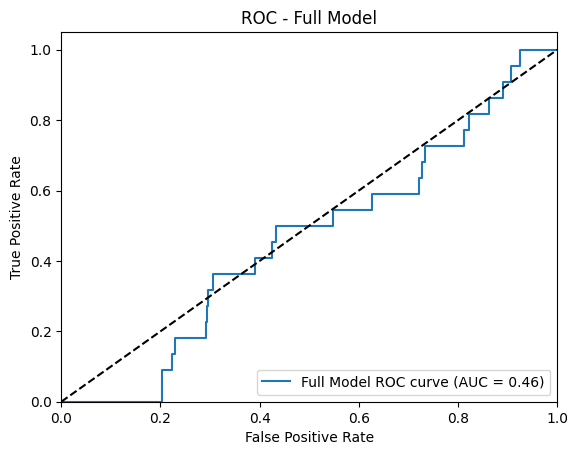

In [24]:
# Evaluate the full model on the test set and plot ROC curve
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out, _ = model(data)
        preds = torch.sigmoid(out).cpu().numpy()
        labels = data.y.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'Full Model ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Full Model')
plt.legend(loc='lower right')
plt.show()
